In [80]:
import json
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import display  # WICHTIG für Jupyter Live-Update
from pandasgui import show
from tqdm import tqdm
import seaborn as sns
from pprint import pprint

import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import CSVLogger, TensorBoard
from tensorflow.keras.layers import Concatenate, Dense, Lambda, Layer, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

from adapt.instance_based import TrAdaBoostR2
from scikeras.wrappers import KerasRegressor

from src.data import NPY
from src.execution import CNNValidationExecution
from src.execution import WindowSplittingExecution
from src.model import CNN
from src.util import timestamp


Domainadaptation mit TradaBoostR2 aus der Adapt Libary
Erste Version, wenns läuft dann später in den Klassen die einzelnen Methoden ergänzen

---
## **Trainingsdaten erzeugen**
Da die Zuordnung der Datenmengen über die Anzahl der Versuche läuft, wird hier nur der Belchsplit durchgeführt, es wird eine bestimmte Anzahl an Blechen gewählt. 

- Trainingsdaten aus den Simulationsdaten werden wie gehabt erzeugt
- Target Domain Daten werden aus den Raldaten erzeugt.   

Simulationsdaten: Blechsplit

In [ ]:
#DATA: str = "assets/synthetic-data.csv"
DATA: str = "assets/data/stationary_data_250402/sim_data_preprocessed_offset_multiplitiv.csv"
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.2
BATCH_SPLIT: bool = True # Blechsplit bei True 
BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "." # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)



In [120]:
#DATA: str = "assets/synthetic-data.csv"
DATA: str = "assets/data/stationary_data_250402/sim_data_preprocessed.csv"
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.2
BATCH_SPLIT: bool = True # Blechsplit bei True 
BATCHSIZE: int = 326 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "." # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)

Anzahl an Bleche in der Gesamtmatrix 178
178.0
Richtige Blechnummern umgerechnet der Validierungsdaten [204, 23, 38, 56, 31, 183, 114, 109, 169, 133, 146, 136, 174, 140, 161, 108, 172, 197]
Richtige Blechnummern umgerechnet der Testdaten [192, 50, 132, 127, 30, 196, 99, 51, 64, 186, 105, 68, 156, 67, 40, 39, 126, 200]
Blechnummern für Validierungsdaten, abgezählt vom Array nicht die Originaldaten [176, 10, 25, 43, 18, 155, 89, 84, 141, 107, 119, 110, 146, 113, 133, 83, 144, 169]
Blechnummern für Testdaten, abgezählt vom Array nicht die Originaldaten[164, 37, 106, 101, 17, 168, 74, 38, 51, 158, 80, 55, 129, 54, 27, 26, 100, 172]
5688
Shape nach dem Random Sampling des Arrays von X_val: (5688, 10, 11)
(5688, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (44872, 10, 11)
Shape für die Features der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (5688, 10, 11) 
Shape für die Labels der gesamten Trainingsdate

Realdaten Blechsplit (`Train_Test_Split = 2`):
- Die Daten trennen in A % Trainingsdaten für den TradaBoostR2 und B % Testdaten
--> Solche Auftielung mti den Vorhandneen Methoden leichter umzusetzen als über exakte Anzahl der Bleche
- Die Domain Adaptation wird auf dem A % Testdaten durchgeführt
- Testen erfolgt auf dem Testdatensatz
- Die Größenverhältnisse der Datensätze werden über die Variable  `size` eingestellt
- `size = 0.9` so werden 10 % der Bleche in das TradaBoost DaomainAdaptaion gegeben, die restlichen 90 % der Daten werden zum Kontrollieren verwndet  

In [ ]:
DATA: str = "assets/data/real-data.csv"
#DATA: str = ""
VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
TEST_SIZE: float = 0.99
BATCH_SPLIT: bool = True
BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
INTERPOLATION: bool = False
WINDOWSIZE: int = 10
SEP: str = ";" # Separator of the csv file
DECIMAL: str = "," # Decimal separator of the csv file

WindowSplittingExecution.execute(DATA, 
                                 BATCH_SPLIT, 
                                 VALIDATION_SPLIT, 
                                 TEST_SIZE, 
                                 SEED, 
                                 BATCHSIZE, 
                                 INTERPOLATION, 
                                 WINDOWSIZE, 
                                 SEP, 
                                 DECIMAL)



## **Kontrolle der Verteilungen**
Verglichen werden die Verteilungen der Inputs und Outputs vor dem Skalierung und danach
Problem: Die Daten der Targetdomain und der Sourcdomain werdne mit unterschiedlichen Scalern skaliert, die skalierten Daten leigen immer übereinander, da mit min max scaliert wird 

In [ ]:
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed\\1743966345"
dateipfad_realDaten="build\\window_split\\experiment-data-subset\\1743966491"	

def plotAllHistOfFIle(file_name):
    # Lade die Daten aus beiden Ordnern
    fem_path = os.path.join(dateipfad_femDaten, file_name)
    real_path = os.path.join(dateipfad_realDaten, file_name)

    # Daten als numpy-Array laden
    fem_data = np.load(fem_path)
    real_data = np.load(real_path)
    fem_data = fem_data.reshape(-1, fem_data.shape[2])  # Shape: (287560, 11)
    real_data = real_data.reshape(-1, real_data.shape[2])  # Shape: (254180, 11)
    # Anzahl der Features (Spalten)
    num_features = fem_data.shape[1]
    print(fem_data.shape)
    print(real_data.shape)
    bins = 50  # Anzahl der Bins für die Histogramme


    # Anzahl der Spalten pro Zeile
    cols = 4
    rows = (num_features + cols - 1) // cols  # Rundet auf, falls nicht durch 4 teilbar

    # Plots erstellen
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # 2D Array in 1D umwandeln für einfachere Iteration

    for i in range(num_features):
        ax = axes[i]
        sns.histplot(fem_data[:, i], bins=bins, kde=True, ax=axes[i], color="blue", label="Simulation", stat="density", alpha=0.6)
        sns.histplot(real_data[:, i], bins=bins, kde=True, ax=axes[i], color="orange", label="Realdaten", stat="density", alpha=0.6)
        ax.set_title(f"Feature {i+1}")
        ax.set_xlabel("Wert")
        ax.set_ylabel("Dichte")
        ax.legend()

    # Leere Subplots deaktivieren, falls es weniger als 4*n Features gibt
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Datei laden



In [ ]:
plotAllHistOfFIle("x-train-scaled.npy")

In [ ]:
plotAllHistOfFIle("y-train-scaled.npy")

## **TradaBoostR2**
- Early stopping und Valiadation enthalten
- Sonsten erstmal Parameter günsitg einstellen, sodass Effekt sichtbar wird
- Modell umschrieben mit neuer Sparse Layer, eine Layer fasst die Outputs von zuvor zusammen 
    - Die Letze Layer wird nun nur sparse besetzt und ist nicht trainierbar
    - Outputs werden direkt in diese Layer weitergegeben, ist so ne Eigenheit von TradaBoostR2, kann nur auf einem Output arbeiten

In [ ]:
@register_keras_serializable(package="custom_layers")
class SparseStackLayer(Layer):
    def __init__(self, **kwargs):
        super(SparseStackLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Kombiniert Liste von Tensoren (z. B. [batch, 1], [batch, 1], [batch, 1])
        # zu einem Tensor mit Shape (batch, 3)
        return tf.concat(inputs, axis=-1)
class LivePlotCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {"loss": [], "val_loss": []}
        #self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        self.history["loss"].append(logs.get("loss", 0))
        self.history["val_loss"].append(logs.get("val_loss", 0))

    def on_train_end(self, logs=None):
        logs = logs or {}
        self.history["loss"].append(logs.get("loss", 0))
        self.history["val_loss"].append(logs.get("val_loss", 0))

        plt.figure(figsize=(6, 4))
        epochs = list(range(1, len(self.history["loss"]) + 1))

        plt.plot(epochs, self.history["loss"], label="Trainingsverlust (Loss)", color="blue", marker="o")
        plt.plot(epochs, self.history["val_loss"], label="Validierungsverlust (Loss)", color="red", linestyle="dashed", marker="o")

        plt.xlabel("Epoche")
        plt.ylabel("Loss")
        plt.title("Training vs. Validierung")
        plt.grid(True)
        plt.legend()
        
        #if self.save_path:
        #    plt.savefig(self.save_path)
        
        display.display(plt.gcf())
def domainAdapt_tradaBoostR2_noProcessDoku(cnn_wrapped,n_estimators_tradaBoostR2,learning_rate_tradaBoostR2,
                                           X_source_scaled,y_source_scaled,
                                           X_target_scaled,y_target_scaled,
                                           X_source_scaled_Test,y_source_scaled_Test,
                                           save_folder, save_filename                    
                                           ):
    print("Keine Prozessdokumentation der einzelnen Iterationen")
    #Dim Reduktion, weil halt
    y_source_scaled=np.squeeze(y_source_scaled)
    y_target_scaled=np.squeeze(y_target_scaled)

    tradaboost_model = TrAdaBoostR2(
        estimator=cnn_wrapped,  # CNN als Basis-Regressor
        n_estimators=n_estimators_tradaBoostR2,  # Anzahl der Boosting-Iterationen
        verbose=1,
        lr=learning_rate_tradaBoostR2,  # Lernrate für den Boosting-Prozess
        Xt=X_target_scaled,  # Ziel-Domain-Daten (Realdaten)
        yt=y_target_scaled,  # Ziel-Domain-Zielwerte (Realdaten)
    )

    tradaboost_model.fit(X_source_scaled, y_source_scaled,validation_data=(X_source_scaled_Test,y_source_scaled_Test)) # TODO Realdaten in Validieurn gaufnehmen
    
    trained_model = tradaboost_model.estimators_[-1]  # Letzter trainierter Estimator
    trained_model.model_.save(os.path.join(save_folder, f"{save_filename}.h5"))

    
def domainAdapt_tradaBoostR2_earlystopping(cnn_wrapped,n_estimators_tradaBoostR2,learning_rate_tradaBoostR2,
                                           X_source_scaled,y_source_scaled,
                                           X_target_scaled,y_target_scaled,
                                           X_source_scaled_Test,y_source_scaled_Test,
                                           save_folder, save_filename                    
                                           ):
    
    #Dim Reduktion, weil halt
    y_source_scaled=np.squeeze(y_source_scaled)
    y_target_scaled=np.squeeze(y_target_scaled)

    training_progress = []
    tradaboost_model = TrAdaBoostR2(
        estimator=cnn_wrapped,  # CNN als Basis-Regressor
        n_estimators=n_estimators_tradaBoostR2,  # Anzahl der Boosting-Iterationen
        verbose=1,
        lr=learning_rate_tradaBoostR2,  # Lernrate für den Boosting-Prozess
        )
    
    print("\n Training mit TrAdaBoostR2 gestartet \n")
    print(f"save_folder = {save_folder}")
    print(f"")
    #tqdm mach interen Schlaife von TradaBoostR2 zu externer schleife um Trainingsprozess zu verfolgen
    with tqdm(total=tradaboost_model.n_estimators, desc="TrAdaBoostR2 Fortschritt") as pbar:
        for i in range(tradaboost_model.n_estimators):
            #Fitten einer Iteration von TradaBoostR2
            tradaboost_model.fit(X=X_source_scaled,y=y_source_scaled,
                                 Xt=X_target_scaled,  # Ziel-Domain-Daten (Realdaten)
                                 yt=y_target_scaled,  # Ziel-Domain-Zielwerte (Realdaten)
                                 validation_data=(X_source_scaled_Test,y_source_scaled_Test)) # TODO Realdaten in Validieurn gaufnehmen
            #Modelle zwischenspeichern für evaluierung des Trainings
            print(f"Modell in interation {i} abspeichern als:{os.path.join(save_folder, f"tradaboost_model_iter_{i}.h5")}")
            keras_model = tradaboost_model.estimators_[-1].model_
            keras_model.save(os.path.join(save_folder, f"tradaboost_model_iter_{i}.h5"))
            #Trainingsprocess speichern
            checkpoint_data = {
                "iteration": i + 1,
                "loss": keras_model.evaluate(X_source_scaled_Test, y_source_scaled_Test, verbose=0),
                "estimator_count": len(tradaboost_model.estimators_),
                "weights": tradaboost_model.estimator_weights_,
                "errors": tradaboost_model.estimator_errors_,
            }
            training_progress.append(checkpoint_data)
            #Updaten des Modellsfortschritts 
            pbar.update(1)
    print("\n Training mit TrAdaBoostR2 beendet \n")
    
    json_path = os.path.join(save_folder, f"tradaBoostR2_trainingProgress.json")
    with open(json_path, 'w') as json_file:
        json.dump(training_progress, json_file, indent=4, default=str)
    
    # Extrahiertes Modell nach dem Training speichern
    trained_model = tradaboost_model.estimators_[-1]  # Letzter trainierter Estimator

    # Modell speichern
    trained_model.model_.save(os.path.join(save_folder, f"{save_filename}.h5"))

def execute_tradaBoostR2_training(dateipfad_femDaten,dateipfad_realDaten,model_file,save_folder,save_filename, learning_rate,
                                  epochs,with_process_Doku=True,n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=1,batch_size=32,patience=3):
    #Simulationsdaten      
    X_source_scaled = NPY.from_file(dateipfad_femDaten + "x-train-scaled.npy").array
    y_source_scaled = NPY.from_file(dateipfad_femDaten + "y-train-scaled.npy").array
    X_source_scaled_Test = NPY.from_file(dateipfad_femDaten + "x-validate-scaled.npy").array
    y_source_scaled_Test = NPY.from_file(dateipfad_femDaten + "y-validate-scaled.npy").array
    # Realdaten
    X_target_scaled = NPY.from_file(dateipfad_realDaten + "x-train-scaled.npy").array
    y_target_scaled = NPY.from_file(dateipfad_realDaten + "y-train-scaled.npy").array

    #Modell erstellen
    cnn = CNN.from_file(model_file)
    outputs = cnn.model.outputs
    combined_output = SparseStackLayer(name="sparse_output")(outputs)
    new_model = tf.keras.Model(inputs=cnn.model.inputs, outputs=combined_output, name="extended_model")
    live_plot_callback = LivePlotCallback()

    new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                    loss="mean_absolute_error", 
                    metrics=["mae"])#TODO Bruache ich diese Zeile?

    early_stopping =keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    #csv_logger = CSVLogger(filename=os.path.join(save_folder, "training_log.csv"), separator=",", append=False)
    csv_logger = CSVLogger(filename=os.path.join(save_folder, "training_log.csv"), separator=",", append=True)
    cnn_wrapped = KerasRegressor(model=new_model, epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[early_stopping,csv_logger,live_plot_callback])
    
    #Dokumentation des Training smit Tradaboost
    initial_training_setup = {
                "Speicherorte": {
                "Modell": model_file,
                "Simulationsdaten": dateipfad_femDaten,
                "Realdaten": dateipfad_realDaten,
                "save_folder": save_folder,
                "save_filename": save_filename,
                "Process Dokumentation": with_process_Doku
                },
                "Training Parameter": {
                 
                "Optimizer": {
                    "name": "Adam",
                    "learning_rate": learning_rate
                },
                "early_stopping": {
                    "patience": patience,
                    "restore_best_weights": True
                },
                "KerasRegressor":{
                    "epochs": epochs,
                    "batch_size": batch_size
                },
                "loss": "mean_absolute_error",
                "metrics": ["mae"]
                },
                "Parameter TradaBoostR2": {
                "n_estimators": n_estimators_tradaBoostR2,
                "learning rate": learning_rate_tradaBoostR2
                },
                "Dimensionen der Daten": {
                    "X_source_scaled": X_source_scaled.shape,
                    "y_source_scaled": y_source_scaled.shape,
                    "X_target_scaled": X_target_scaled.shape,
                    "y_target_scaled": y_target_scaled.shape,
                    "X_source_scaled_Test": X_source_scaled_Test.shape,
                    "y_source_scaled_Test": y_source_scaled_Test.shape
                }
                }
    
    # Speichern der Dokumentation in einer JSON-Datei
    json_path = os.path.join(save_folder, f"tradaBoostR2_training_BasisParameter.json")
    with open(json_path, 'w') as json_file:
        json.dump(initial_training_setup, json_file, indent=4, default=str)
    
    start_time = time.time()
    if with_process_Doku==True:
        domainAdapt_tradaBoostR2_earlystopping(cnn_wrapped=cnn_wrapped,n_estimators_tradaBoostR2=n_estimators_tradaBoostR2,
                                            learning_rate_tradaBoostR2=learning_rate_tradaBoostR2,
                                            X_source_scaled=X_source_scaled,y_source_scaled=y_source_scaled,
                                            X_target_scaled=X_target_scaled,y_target_scaled=y_target_scaled,
                                            X_source_scaled_Test=X_source_scaled_Test,y_source_scaled_Test=y_source_scaled_Test,
                                            save_folder=save_folder, save_filename=save_filename)
    else:
        domainAdapt_tradaBoostR2_noProcessDoku(cnn_wrapped=cnn_wrapped,n_estimators_tradaBoostR2=n_estimators_tradaBoostR2,
                                            learning_rate_tradaBoostR2=learning_rate_tradaBoostR2,
                                            X_source_scaled=X_source_scaled,y_source_scaled=y_source_scaled,
                                            X_target_scaled=X_target_scaled,y_target_scaled=y_target_scaled,
                                            X_source_scaled_Test=X_source_scaled_Test,y_source_scaled_Test=y_source_scaled_Test,
                                            save_folder=save_folder, save_filename=save_filename)
    end_time = time.time()
    dauer = {"Rechendauer " : end_time - start_time}
    json_path = os.path.join(save_folder, f"Rechendauer.json")
    with open(json_path, 'w') as json_file:
        json.dump(dauer, json_file, indent=4, default=str)
    



In [ ]:
#dateipfad_femDaten="build\\window_split\\sim_data_preprocessed\\1743966827\\"
#dateipfad_realDaten="build\\window_split\\experiment-data-subset\\1743966820\\"
#model_file = "assets\\tuned-synthetic-data-offset\\1742400473\\best-model.h5"
#model_file = "assets\\tuned-synthetic-data-offset\\1742239520\\cnn-synthetic-data-offset.h5"
#save_folder=r'build\tradaboost_model\test_training'
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed_offset_multiplitiv\\1744056915\\"
dateipfad_realDaten="build\\window_split\\real-data\\1744062620\\"
model_file = "assets\\models\\untrained\\sim_data_preprocessed\\1743665223\\best-model.h5"
best_learning_rate=0.0005026453831067469
save_folder = os.path.join("build", "tradaboost_model", "training_09")
save_filename="training_09"

execute_tradaBoostR2_training(with_process_Doku=False,dateipfad_femDaten=dateipfad_femDaten,dateipfad_realDaten=dateipfad_realDaten,
                              model_file=model_file,save_folder=save_folder,save_filename=save_filename,n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=0.7,
                              learning_rate=best_learning_rate,epochs=6,batch_size=32,patience=3)

Es werden immer alle Simulationsdaten verwendet: Ein 80/20 Split
Training des Modells für unterschiedliche Anteile an Realdaten:
- Beginnend bei 80% der Realdaten für das Training und 20% für die Evaluation
- Danach Verringern um 10% Schritte auf 10%
- Extremtests mit 5% 3% und 1% der Realdaten

In [180]:
#training_base=[90,80,70,60,50,40,30,20,10,7,5,3,1] # Prozentualer Anteil der Target-Trainings-Daten an den Gesamttargetdaten
training_base=[80,60,40,20,10,5] # Prozentualer Anteil der Target-Trainings-Daten an den Gesamttargetdaten
for anteil in training_base:
    test_size=(100-anteil)/100
    print(f"Testsize: {test_size}")
    DATA: str = "assets/data/real-data.csv"
    VALIDATION_SPLIT: bool = True # If the data should also be splitted into a validation set?
    TEST_SIZE: float = (100-anteil)/100
    BATCH_SPLIT: bool = True
    BATCHSIZE: int = 1800 # real-data: 1800, synthetic-data: 326
    SEED: int = 69 # Seed for random state -> Split with same seed and data will always result in the same split
    INTERPOLATION: bool = False
    WINDOWSIZE: int = 10
    SEP: str = ";" # Separator of the csv file
    DECIMAL: str = "," # Decimal separator of the csv file
    
    WindowSplittingExecution.execute(DATA, 
                                    BATCH_SPLIT, 
                                    VALIDATION_SPLIT, 
                                    TEST_SIZE, 
                                    SEED, 
                                    BATCHSIZE, 
                                    INTERPOLATION, 
                                    WINDOWSIZE, 
                                    SEP, 
                                    DECIMAL)


Testsize: 0.2
Anzahl an Bleche in der Gesamtmatrix 142
142.0
Richtige Blechnummern umgerechnet der Validierungsdaten [23, 38, 56, 31, 114, 109, 133, 146, 136, 140, 108, 160, 50, 132]
Richtige Blechnummern umgerechnet der Testdaten [64, 22, 67, 156, 32, 39, 150, 53, 41, 165, 110, 123, 118, 78]
Blechnummern für Validierungsdaten, abgezählt vom Array nicht die Originaldaten [10, 25, 43, 18, 89, 84, 107, 119, 110, 113, 83, 132, 37, 106]
Blechnummern für Testdaten, abgezählt vom Array nicht die Originaldaten[51, 9, 54, 129, 19, 26, 123, 40, 28, 137, 85, 97, 93, 65]
25060
Shape nach dem Random Sampling des Arrays von X_val: (25060, 10, 11)
(25060, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (204060, 10, 11)
Shape für die Features der gesamten Testdaten, also im Falle einer Interpolation mit allen Daten (25060, 10, 11) 
Shape für die Labels der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (204060, 1,

In [181]:
#Trainieren der Modelle
upper_Directory="build\\window_split\\real-data\\Realdaten_80_60_40_20_10_5"
subfolder_paths = [
    os.path.join(upper_Directory, name) +'\\'
    for name in os.listdir(upper_Directory)
    if os.path.isdir(os.path.join(upper_Directory, name))
]
print(subfolder_paths)
#Ordner für Modelle erstellen
base_dir = "build\\tradaboost_model\\training_12_Realdaten_80_60_40_20_10_5_Prozent"  # <-- hier anpassen
start_index = 1
end_index = 6
prefix = "training_12"
speicherort_modell=[]
for i in range(start_index, end_index + 1):
    folder_name = f"{prefix}_{i:02d}"
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"✅ Erstellt: {folder_path}")
    else:
        print(f"⏭️ Übersprungen (existiert schon): {folder_path}")
    speicherort_modell.append(folder_path+"\\")
print("")
print(speicherort_modell)
#Trainieren der Modelle


['build\\window_split\\real-data\\Realdaten_80_60_40_20_10_5\\1744150907\\', 'build\\window_split\\real-data\\Realdaten_80_60_40_20_10_5\\1744150924\\', 'build\\window_split\\real-data\\Realdaten_80_60_40_20_10_5\\1744150943\\', 'build\\window_split\\real-data\\Realdaten_80_60_40_20_10_5\\1744150962\\', 'build\\window_split\\real-data\\Realdaten_80_60_40_20_10_5\\1744150980\\', 'build\\window_split\\real-data\\Realdaten_80_60_40_20_10_5\\1744150999\\']
✅ Erstellt: build\tradaboost_model\training_12_Realdaten_80_60_40_20_10_5_Prozent\training_12_01
✅ Erstellt: build\tradaboost_model\training_12_Realdaten_80_60_40_20_10_5_Prozent\training_12_02
✅ Erstellt: build\tradaboost_model\training_12_Realdaten_80_60_40_20_10_5_Prozent\training_12_03
✅ Erstellt: build\tradaboost_model\training_12_Realdaten_80_60_40_20_10_5_Prozent\training_12_04
✅ Erstellt: build\tradaboost_model\training_12_Realdaten_80_60_40_20_10_5_Prozent\training_12_05
✅ Erstellt: build\tradaboost_model\training_12_Realdaten_8

Trainingsdaten: build\window_split\real-data\Realdaten_80_60_40_20_10_5\1744150907\
Speicherort: build\tradaboost_model\training_12_Realdaten_80_60_40_20_10_5_Prozent\training_12_01\


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Keine Prozessdokumentation der einzelnen Iterationen


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 



Epoch 1/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.3187 - mae: 0.2472 - val_loss: 0.9241 - val_mae: 0.8976
Epoch 2/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.1894 - mae: 0.1626 - val_loss: 0.9310 - val_mae: 0.9035
Epoch 3/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1550 - mae: 0.1284 - val_loss: 0.9153 - val_mae: 0.8899
Epoch 4/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.1443 - mae: 0.1195 - val_loss: 0.9179 - val_mae: 0.8946
Epoch 5/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1368 - mae: 0.1139 - val_loss: 0.9068 - val_mae: 0.8852
Epoch 6/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1317 - mae: 0.1105 - val_loss: 0.9239 - val_mae: 0.9035
Epoch 7/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1298 - mae: 0.1095 - val_loss: 0.9220 - val_mae: 0.9021
Epoch 8/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1274 - mae: 0.1075 - val_loss: 0.9091 - val_mae: 0.8897
Epoch 9/10
7780/7780 ━━━━━━━━━━━

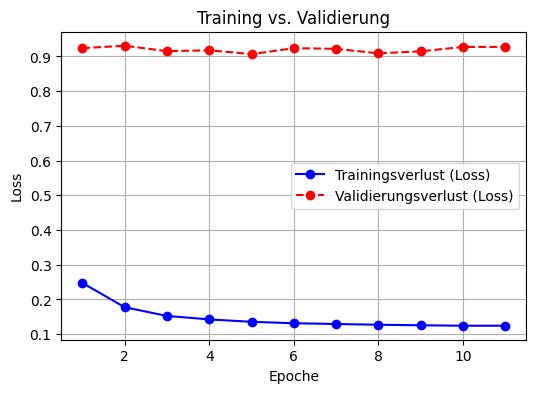

1403/1403 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 6s 973us/step
Iteration 0 - Error: 0.0598


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 



Epoch 1/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.3414 - mae: 0.2428 - val_loss: 0.9418 - val_mae: 0.9124
Epoch 2/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2089 - mae: 0.1516 - val_loss: 0.9695 - val_mae: 0.9370
Epoch 3/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1756 - mae: 0.1308 - val_loss: 0.9395 - val_mae: 0.9066
Epoch 4/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1616 - mae: 0.1196 - val_loss: 0.9372 - val_mae: 0.9065
Epoch 5/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.1551 - mae: 0.1160 - val_loss: 0.9486 - val_mae: 0.9193
Epoch 6/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.1509 - mae: 0.1137 - val_loss: 0.9319 - val_mae: 0.9039
Epoch 7/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.1475 - mae: 0.1119 - val_loss: 0.9175 - val_mae: 0.8898
Epoch 8/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.1441 - mae: 0.1097 - val_loss: 0.9230 - val_mae: 0.8957
Epoch 9/10
7780/7780 ━━━━━━━━━━━

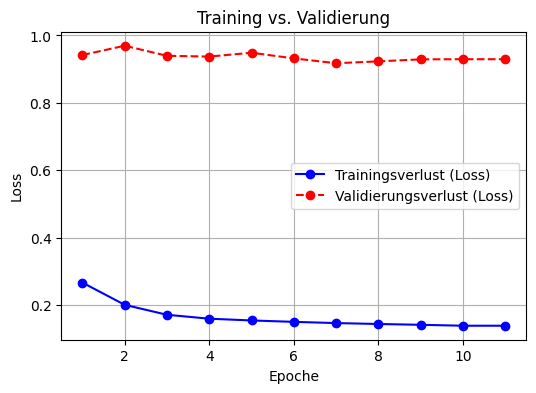

1403/1403 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Iteration 1 - Error: 0.0687


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 



Epoch 1/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.3686 - mae: 0.2559 - val_loss: 0.9222 - val_mae: 0.8902
Epoch 2/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.2386 - mae: 0.1618 - val_loss: 0.9133 - val_mae: 0.8797
Epoch 3/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2043 - mae: 0.1421 - val_loss: 0.9136 - val_mae: 0.8762
Epoch 4/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1762 - mae: 0.1348 - val_loss: 0.9199 - val_mae: 0.8830
Epoch 5/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1615 - mae: 0.1275 - val_loss: 0.8941 - val_mae: 0.8561
Epoch 6/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1530 - mae: 0.1222 - val_loss: 0.9079 - val_mae: 0.8707
Epoch 7/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.1477 - mae: 0.1182 - val_loss: 0.9051 - val_mae: 0.8686
Epoch 8/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1441 - mae: 0.1155 - val_loss: 0.8819 - val_mae: 0.8464
Epoch 9/10
7780/7780 ━━━━━━━━━━━

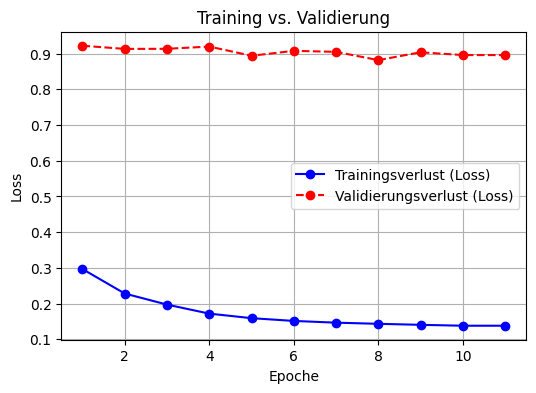

1403/1403 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Iteration 2 - Error: 0.0451


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 



Epoch 1/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.3738 - mae: 0.2607 - val_loss: 0.9643 - val_mae: 0.9322
Epoch 2/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2392 - mae: 0.1654 - val_loss: 0.9651 - val_mae: 0.9288
Epoch 3/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.1950 - mae: 0.1461 - val_loss: 0.9927 - val_mae: 0.9512
Epoch 4/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1690 - mae: 0.1382 - val_loss: 0.9782 - val_mae: 0.9348
Epoch 5/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1537 - mae: 0.1261 - val_loss: 0.9615 - val_mae: 0.9197
Epoch 6/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1466 - mae: 0.1209 - val_loss: 0.9396 - val_mae: 0.8993
Epoch 7/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1417 - mae: 0.1180 - val_loss: 0.9670 - val_mae: 0.9285
Epoch 8/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1371 - mae: 0.1149 - val_loss: 0.9566 - val_mae: 0.9182
Epoch 9/10
7780/7780 ━━━━━━━━━━━

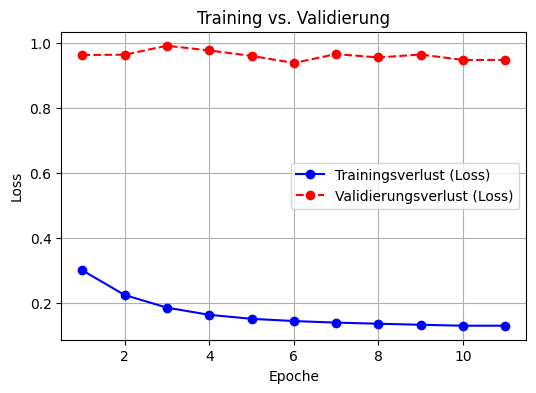

1403/1403 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Iteration 3 - Error: 0.0688


c:\Users\Patrick R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 



Epoch 1/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.3840 - mae: 0.2782 - val_loss: 0.9789 - val_mae: 0.9457
Epoch 2/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.2471 - mae: 0.1749 - val_loss: 0.9439 - val_mae: 0.9146
Epoch 3/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2262 - mae: 0.1621 - val_loss: 0.9493 - val_mae: 0.9183
Epoch 4/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2100 - mae: 0.1545 - val_loss: 0.9752 - val_mae: 0.9342
Epoch 5/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1848 - mae: 0.1507 - val_loss: 0.9937 - val_mae: 0.9487
Epoch 6/10
7780/7780 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1700 - mae: 0.1417 - val_loss: 0.9824 - val_mae: 0.9388
Epoch 7/10
4751/7780 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1619 - mae: 0.1377

In [ ]:
dateipfad_femDaten="build\\window_split\\sim_data_preprocessed\\1744139600\\"
model_file = "assets\\models\\untrained\\sim_data_preprocessed\\1743665223\\best-model.h5"
best_learning_rate=0.0005026453831067469
for idx,(data_path,model_save_path) in enumerate(zip(subfolder_paths, speicherort_modell)):
    print("========================================================================")
    print(f"Trainingsdaten: {data_path}")
    print(f"Speicherort: {model_save_path}")
    execute_tradaBoostR2_training(with_process_Doku=False,dateipfad_femDaten=dateipfad_femDaten,dateipfad_realDaten=data_path,
                              model_file=model_file,save_folder=model_save_path,save_filename="best_model",n_estimators_tradaBoostR2=5,learning_rate_tradaBoostR2=1,
                              learning_rate=best_learning_rate,epochs=10,batch_size=32,patience=10)


### **Validierung**

In [ ]:
trained_model_file = "build\\tradaboost_model\\training_08\\training_08.h5"
dateipfad_realDaten="build\\window_split\\real-data\\1744062620\\"
trained_model = CNN.from_file(trained_model_file)
X_target_val_scaled = NPY.from_file(dateipfad_realDaten + "x-test-scaled.npy").array
y_target_val_scaled = NPY.from_file(dateipfad_realDaten + "y-test-scaled.npy").array
print(f"X_target_val_scaled.shape = {X_target_val_scaled.shape}")
print(f"y_target_val_scaled.shape = {y_target_val_scaled.shape}")
y_target_val_scaled = np.squeeze(y_target_val_scaled)
print(f"y_target_val_scaled.shape = {y_target_val_scaled.shape}")

loss,error  = trained_model.model.evaluate(X_target_val_scaled,y_target_val_scaled, verbose=1)
print("Allgemeine Evaluation")
print(f"loss = {loss}")
print(f"error = {error}")

predictions = trained_model.model.predict(X_target_val_scaled)


### **Evaluation**

Trainingsprocess von Tradaboost bewerten

In [130]:
def eval_model(model, X_val, y_val):
    # Vorhersagen für die Validierungsdaten
    predictions = model.model.predict(X_val)

    error_X = np.abs(predictions[:, 0] - y_val[:, 0])  # Fehler für Verstellweg_X
    error_Y = np.abs(predictions[:, 1] - y_val[:, 1])  # Fehler für Verstellweg_Y
    error_Phi = np.abs(predictions[:, 2] - y_val[:, 2])  # Fehler für Verstellweg_Phi

    # Berechne den mittleren absoluten Fehler (MAE)
    mae_X = np.mean(error_X)
    mae_Y = np.mean(error_Y)
    mae_Phi = np.mean(error_Phi)

    # Berechne den mittleren quadratischen Fehler (MSE)
    mse_X = np.mean((predictions[:, 0] - y_val[:, 0]) ** 2)
    mse_Y = np.mean((predictions[:, 1] - y_val[:, 1]) ** 2)
    mse_Phi = np.mean((predictions[:, 2] - y_val[:, 2]) ** 2)

    # Berechne die Quadratwurzel des mittleren quadratischen Fehlers (RMSE)
    rmse_X = np.sqrt(mse_X)
    rmse_Y = np.sqrt(mse_Y)
    rmse_Phi = np.sqrt(mse_Phi)

    # Erstelle ein DataFrame für die Ergebnisse
    results = {
        'Metrik': ['MAE', 'MSE', 'RMSE'],
        'Verstellweg_X': [mae_X, mse_X, rmse_X],
        'Verstellweg_Y': [mae_Y, mse_Y, rmse_Y],
        'Verstellweg_Phi': [mae_Phi, mse_Phi, rmse_Phi]
    }
    return results


def process_all_results(base_dir):
    results = []  # Liste zur Speicherung aller Ergebnisse

    # Durchlaufe alle Einträge im Basisverzeichnis
    for entry in os.listdir(base_dir):
        subfolder = os.path.join(base_dir, entry)
        if os.path.isdir(subfolder):
            # Pfade zu den benötigten Dateien im aktuellen Unterordner
            json_file = os.path.join(subfolder, "tradaBoostR2_training_BasisParameter.json")
            model_file = os.path.join(subfolder, "best_model.h5")
            
            # Prüfe, ob die erforderlichen Dateien existieren
            if os.path.exists(json_file) and os.path.exists(model_file):
                # Einlesen der JSON-Datei
                with open(json_file, "r", encoding="utf-8") as f:
                    params = json.load(f)
                
                # Einlesen des Modells
                model = CNN.from_file(model_file)
                
                # Hole den Pfad zu den Testdaten aus dem JSON (im Feld "Speicherorte" -> "Realdaten")
                # Achte darauf, dass der Pfad eventuell relativ oder absolut vorliegt.
                real_data_path = params.get("Speicherorte", {}).get("Realdaten", None)
                dimension_trainingdaten= params.get("Dimensionen der Daten", {}).get("X_source_scaled", None)
                dimension_validationdaten= params.get("Dimensionen der Daten", {}).get("X_source_scaled_Test", None)
                dimension_realdaten= params.get("Dimensionen der Daten", {}).get("X_target_scaled", None)
                if real_data_path is None:
                    print(f"Warnung: Kein 'Realdaten'-Pfad in {json_file} gefunden.")
                    continue

                # Erstelle die Dateipfade zu den Testdaten
                x_test_file = os.path.join(real_data_path, "x-test-scaled.npy")
                y_test_file = os.path.join(real_data_path, "y-test-scaled.npy")

                # Einlesen der Testdaten
                if os.path.exists(x_test_file) and os.path.exists(y_test_file):
                    # Annahme: NPY.from_file gibt ein Objekt zurück, dessen .array das eigentliche NumPy-Array ist.
                    X_target_val_scaled = NPY.from_file(x_test_file).array
                    y_target_val_scaled = NPY.from_file(y_test_file).array

                    # Evaluieren des Modells auf den Target-Validierungsdaten
                    evaluation = eval_model(model, X_target_val_scaled, np.squeeze(y_target_val_scaled))
                else:
                    print(f"Testdaten nicht gefunden in: {real_data_path}")
                    evaluation = None

                # Speichern der Ergebnisse in einem Dictionary
                result_entry = {
                    "subfolder": entry,         # Name des Unterordners
                    #"parameters": params,       # Ausgelesene Parameter aus der JSON-Datei
                    "Anzahl Trainingsdaten": dimension_trainingdaten[0], # Anzahl der Trainingsdaten
                    "Anzahl Validierungsdaten": dimension_validationdaten[0], # Anzahl der Validierungsdaten
                    "Anzahl Realdaten": dimension_realdaten[0], # Anzahl der Realdaten
                    "evaluation": evaluation,   # Ergebnis der Evaluierung
                    # Falls gewünscht: Speichere auch weitere Infos, z.B. das geladene Modell oder Dateien.
                }
                
                results.append(result_entry)
            else:
                print(f"Erforderliche Dateien fehlen in: {subfolder}")

    return results


In [178]:
def get_plottable_data(ergebnissliste):
    
    #Ergebnisse in Liste umwandeln
    aufbereitete_ergebnisse = []
    for eintrag in ergebnissliste:
        anzahl_realdaten = eintrag.get("Anzahl Realdaten", None)
        fehler_evaluation = eintrag.get("evaluation", None)
        if anzahl_realdaten is not None and fehler_evaluation is not None:
            aufbereitete_ergebnisse.append({
                "Anzahl Realdaten": anzahl_realdaten,
                "evaluation": fehler_evaluation
            })
    aufbereitete_ergebnisse = sorted(aufbereitete_ergebnisse, key=lambda x: x["Anzahl Realdaten"])
    return aufbereitete_ergebnisse
    # Plotten der Ergebnisse    
    
def plotten_TradaBoostR2_Ergebnisse(ergebnissliste,marker,color,fig=None,axes=None,overwrite_x_tics=None,label=None):
    metrics = ['MAE', 'MSE', 'RMSE']
    verstellweg_labels = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']
    if fig is None or axes is None:
        print("Erstelle neue Figur und Achsen")
        fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    
    # Durchlaufe die Metriken und Verstellwege
    first=True
    for row, verstellweg in enumerate(verstellweg_labels):
        for col, metric in enumerate(metrics):
            # Extrahiere die Daten für die aktuelle Metrik und den Verstellweg
            for training,x_tick in zip(ergebnissliste,overwrite_x_tics):
                anzahl_realdaten = training["Anzahl Realdaten"]
                errors = training["evaluation"]
                # Plotten
                ax = axes[row, col]
                if overwrite_x_tics is None:
                    if first:
                        ax.plot(anzahl_realdaten, errors[verstellweg][col], marker=marker,color=color, label=label)
                        first=False
                    else:
                        ax.plot(anzahl_realdaten, errors[verstellweg][col], marker=marker,color=color)
                else:
                    if first:
                        ax.plot(x_tick, errors[verstellweg][col], marker=marker, label=label,color=color)
                        first=False
                    else:
                        ax.plot(x_tick, errors[verstellweg][col], marker=marker, color=color)
                ax.set_title(f"{verstellweg} - {metric}")
                ax.set_xlabel('Anteil der Realdaten in %')
                ax.set_ylabel('Fehler')
                ax.grid(True)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')  # Oder eine andere Position
    plt.tight_layout()
    plt.legend()
    return fig, axes

Auswertung Modell training_10

Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 2s 908us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 3s 897us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 3s 985us/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


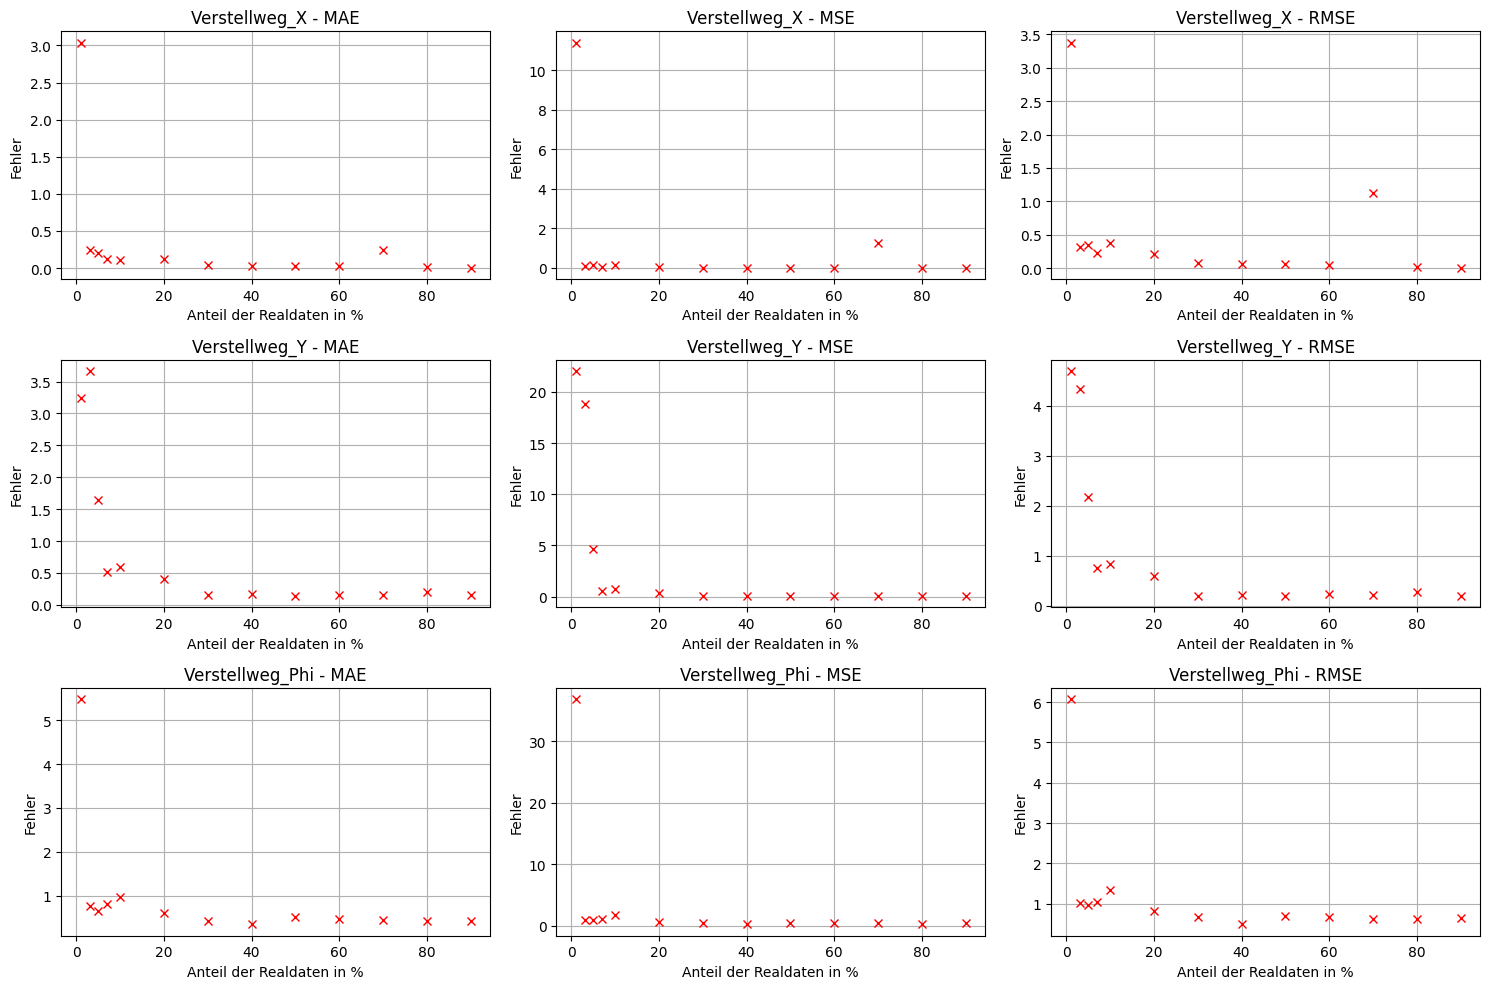

Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3804/3804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Model: "extended_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 3)     │        135 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 5, 3)      │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      4,096 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │        257 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sparse_output       │ (None, 3)         │          0 │ Verstellweg_X[0]… │
│ (SparseStackLayer)  │                   │            │ Verstellweg_Y[0]… │
│                     │                   │            │ Verstellweg_Phi[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,004 (19.55 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


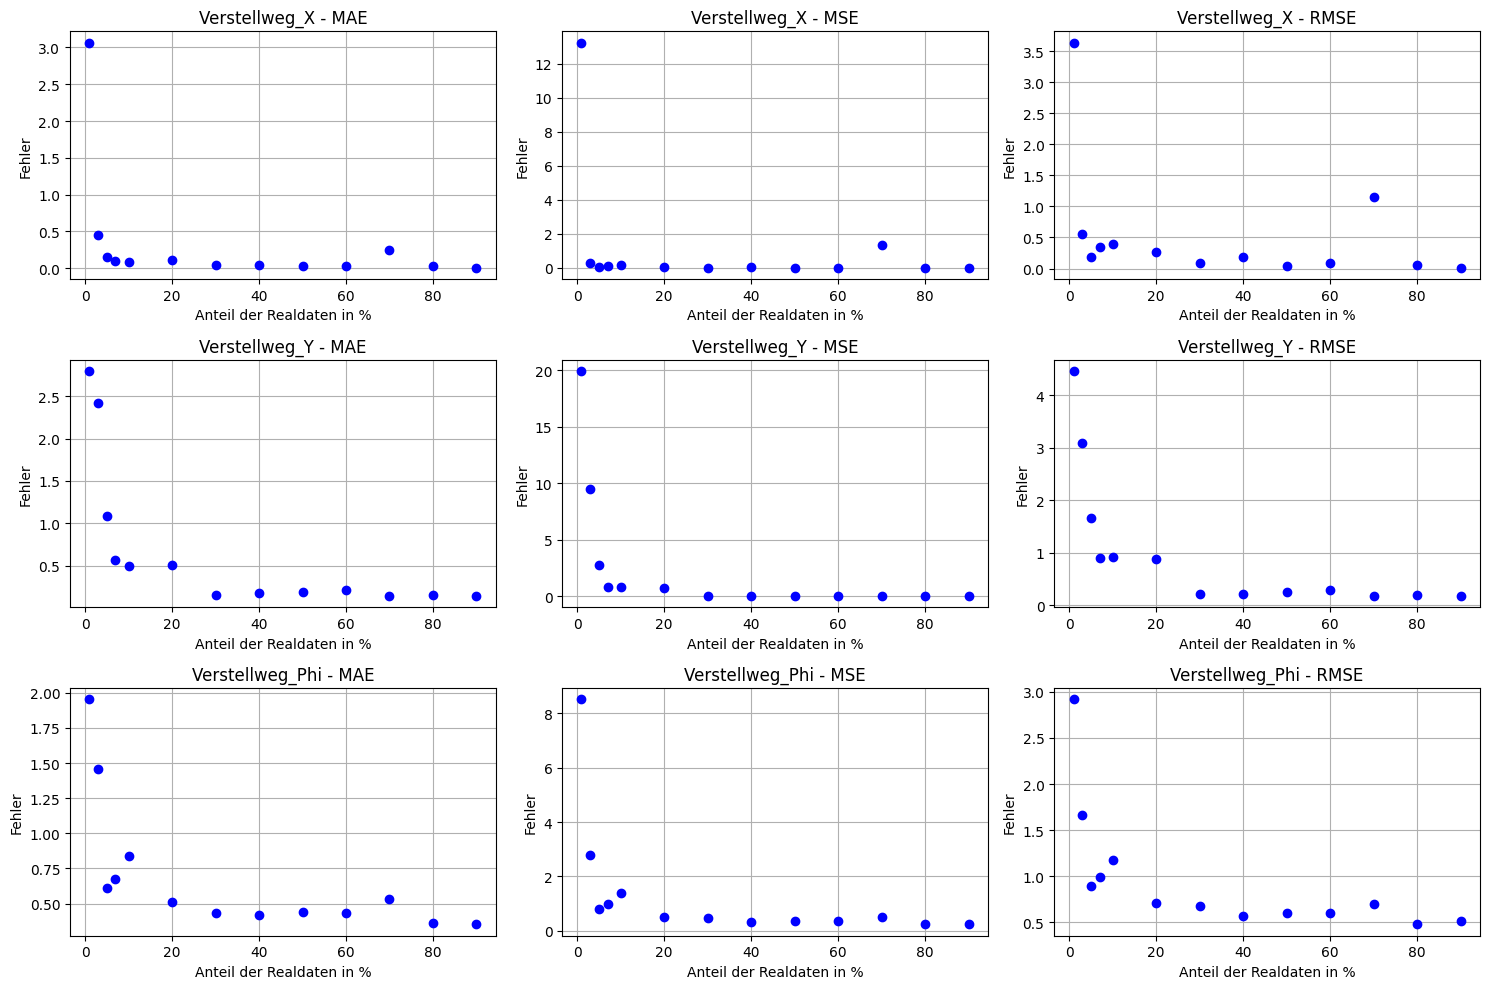

In [ ]:
#Experiment 10
dateipfad_training_10="build\\tradaboost_model\\training_10_90bis1ProzentRealdaten"
process_training_10=process_all_results(dateipfad_training_10)
ergebnisse_training_10=get_plottable_data(process_training_10)
#Experiment 11
dateipfad_training_11="build\\tradaboost_model\\training_11_90bis1ProzentRealdaten"
process_training_11=process_all_results(dateipfad_training_11)
ergebnisse_training_11=get_plottable_data(process_training_11)


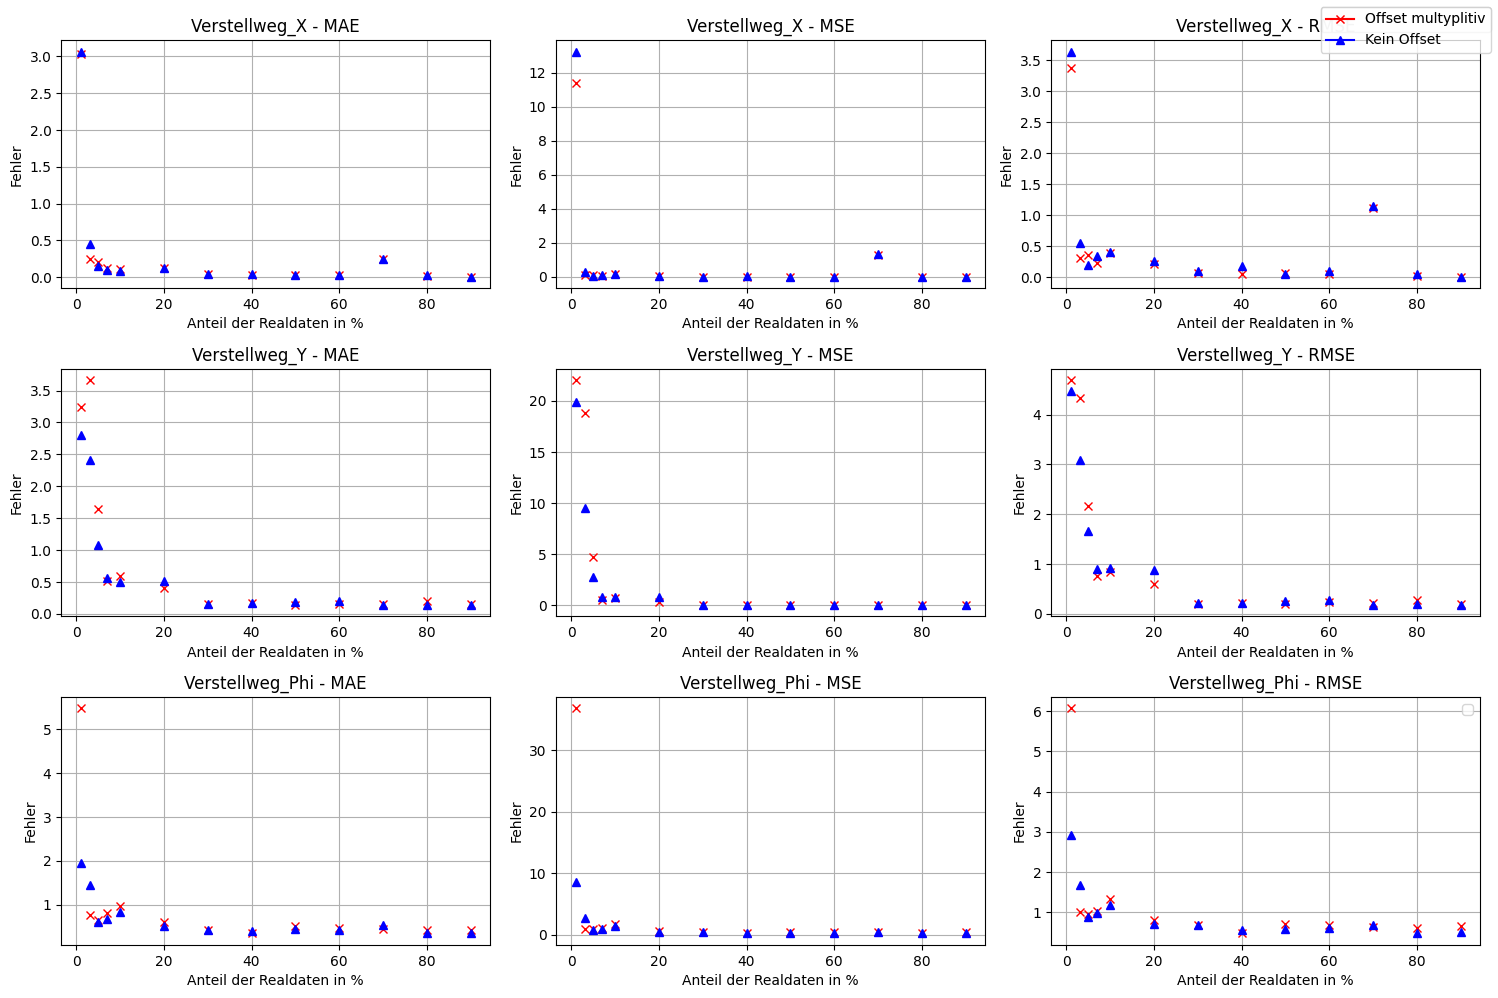

In [179]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig, axes=plotten_TradaBoostR2_Ergebnisse(ergebnisse_training_10,label="Offset multyplitiv",
                                          overwrite_x_tics=[90,80,70,60,50,40,30,20,10,7,5,3,1][::-1],color="red",marker="x",fig=fig,axes=axes)
fig, axes=plotten_TradaBoostR2_Ergebnisse(ergebnisse_training_11,label="Kein Offset",
                                          overwrite_x_tics=[90,80,70,60,50,40,30,20,10,7,5,3,1][::-1],color="blue",marker="^",fig=fig,axes=axes)

Plotten des Trainingsfortschritts

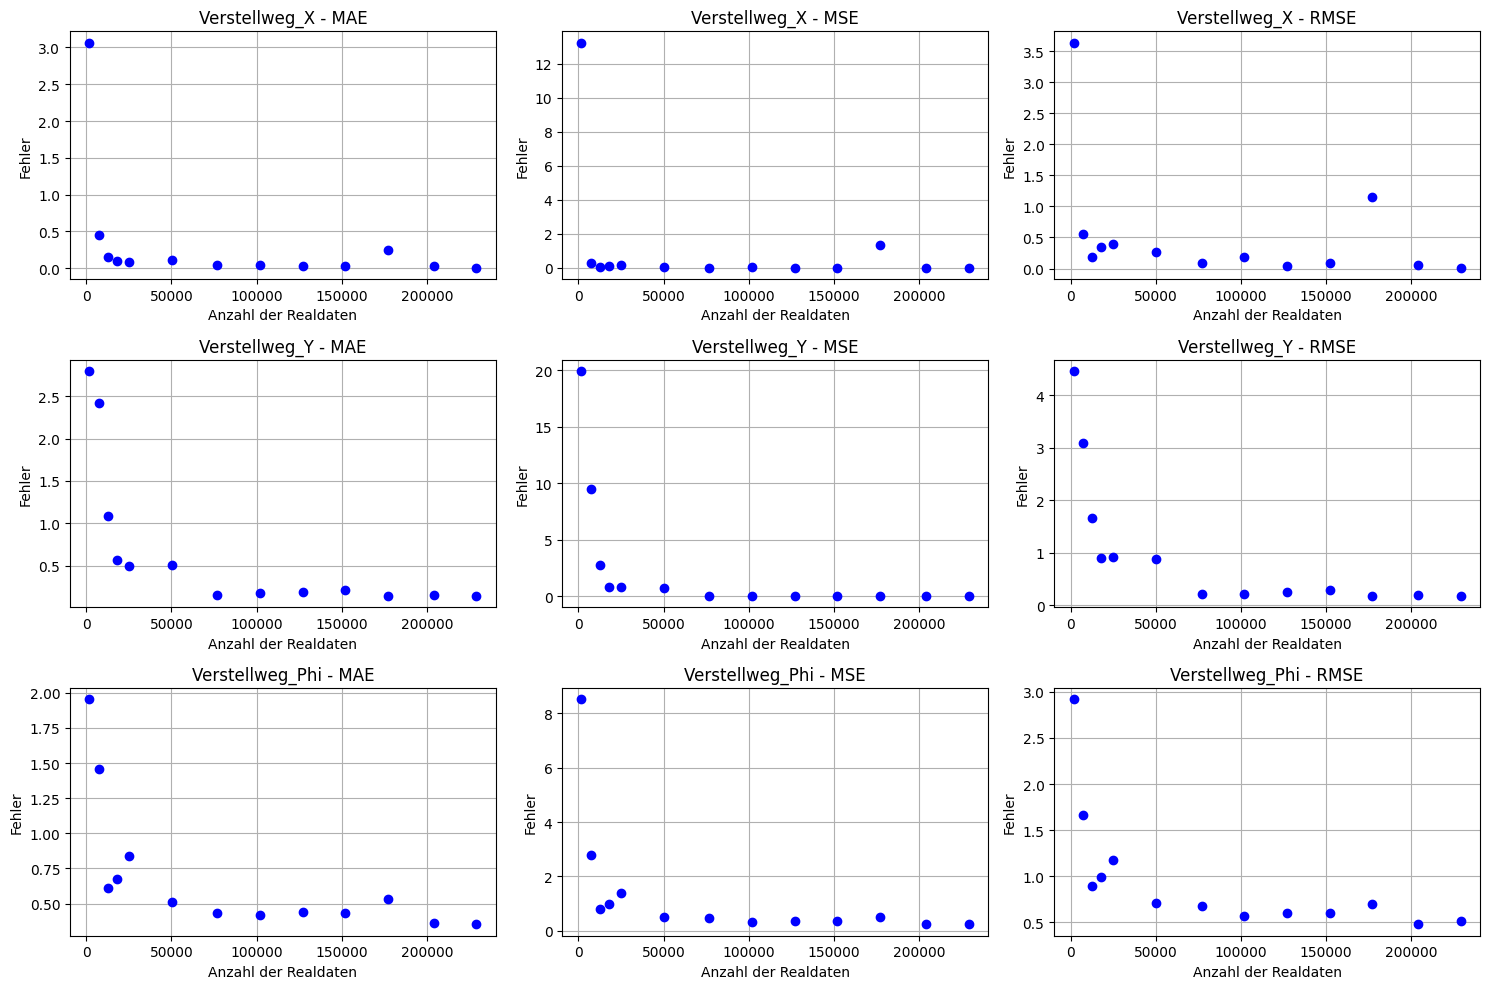

In [126]:
#pprint(ergebnisse_training_10)
plotten_TradaBoostR2_Ergebnisse(ergebnisse_training_11)

In [ ]:
#Durchgehen aller Modelle aus savefolder und evaluieren
errors = []
trained_model_file = "build\\tradaboost_model\\training_09\\training_09.h5"
dateipfad_realDaten="build\\window_split\\real-data\\1744062620\\"
for filename in os.listdir(save_folder):
    if filename.startswith("tradaboost_model_iter_") and filename.endswith(".h5"):
        model_path = os.path.join(save_folder, filename)
        trained_model = CNN.from_file(trained_model_file)
        error=eval_model(trained_model, X_target_val_scaled, y_target_val_scaled)
        errors.append(error)
       

In [ ]:
print(errors)
#show(pd.DataFrame(errors))

# Die Metriken, die wir verwenden
metrics = ['MAE', 'MSE', 'RMSE']

# Die Verstellwege
verstellweg_labels = ['Verstellweg_X', 'Verstellweg_Y', 'Verstellweg_Phi']

# Erstelle das Plot-Grid (3 Zeilen, 3 Spalten)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Durchlaufe die Metriken und Verstellwege
for row, verstellweg in enumerate(verstellweg_labels):
    for col, metric in enumerate(metrics):
        # Extrahiere die Daten für die aktuelle Metrik und den Verstellweg
        data_values = [entry[verstellweg][col] for entry in errors]
        
        # Plotten
        ax = axes[row, col]
        ax.plot(range(len(data_values)), data_values, marker='o', label=metric)
        ax.set_title(f"{verstellweg} - {metric}")
        ax.set_xlabel('Modelle')
        ax.set_ylabel('Fehler')
        ax.grid(True)

# Layout anpassen
plt.tight_layout()
plt.show()